In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import text2synth

import torch
import matplotlib.pyplot as plt
import IPython.display as ipd

import random

In [3]:
# Generate random frequency data

# Constants
DURATION = 1.0  # [seconds]
SAMPLE_RATE = 16e3  # [Hz]
NUM_FRAMES = int(DURATION * SAMPLE_RATE)
NUM_PITCHES = 40
NUM_PARAMS = 10

def plot(freq, waveform, sample_rate, zoom=False, vol=0.1):
    """
    Plot frequency, waveform, and spectrogram information (as well as audio playback).
    Args:
        freq: Tensor of shape (time), in Hz.
        waveform: Tensor of shape (time) in amplitude (?).
        sample_rate: Float in Hz.
        zoom: Boolean to display "zoomed" in waveform.
        vol: Float [0,1] (WARNING: keep low, gets loud).
    """
    freq = freq.detach()
    waveform = waveform.detach()
    t = (torch.arange(waveform.size(0)) / sample_rate).numpy()

    fig, axes = plt.subplots(3, 1, sharex=True)
    axes[0].plot(t, freq.numpy())
    axes[0].set(title="Waveform", ylabel="Frequency [Hz]", ylim=[-0.03, None])
    axes[1].plot(t, waveform)
    axes[1].set(ylabel="Waveform")
    axes[2].specgram(waveform, Fs=sample_rate)
    axes[2].set(ylabel="Spectrogram", xlabel="Time [s]", xlim=[-0.01, t[-1] + 0.01])

    for i in range(3):
        axes[i].grid(True)
    pos = axes[2].get_position()
    fig.tight_layout()

    if zoom:
        ax = fig.add_axes([pos.x0 + 0.02, pos.y0 + 0.32, pos.width / 2.5, pos.height / 2.0])
        ax.plot(t, waveform)
        ax.set(xlim=(1 / SAMPLE_RATE, 3 / SAMPLE_RATE), xticks=[], yticks=[])

    waveform /= waveform.abs().max()
    return ipd.Audio(vol * waveform, rate=sample_rate, normalize=False)

Fs = torch.linspace(10, 8e3, 1000) # Human audible range

# Different waveforms
sin_osc = text2synth.SinOscillator(SAMPLE_RATE)
sq_osc = text2synth.SquareOscillator(SAMPLE_RATE, NUM_PITCHES)
tri_osc = text2synth.TriangleOscillator(SAMPLE_RATE, NUM_PITCHES)
saw_osc = text2synth.SawtoothOscillator(SAMPLE_RATE, NUM_PITCHES)

waves = []
for f in Fs:
    full = torch.full((1, NUM_FRAMES), f, dtype=torch.float64, requires_grad=False)
    waves.append(sin_osc(full))
    waves.append(sq_osc(full))
    waves.append(tri_osc(full))
    waves.append(saw_osc(full))

c:\Users\12345\Documents\Dev\ece180\text2synth_engine\.venv\Lib\site-packages\torchaudio\prototype\functional\_dsp.py:63: UserWarning: Some frequencies are above nyquist frequency. Setting the corresponding amplitude to zero. This might cause numerically unstable gradient.
  warnings.warn(
C:\Users\12345\Documents\Dev\ece180\text2synth_engine\src\text2synth\oscillator.py:61: UserWarning: Some frequencies exceed Nyquist frequency (8000.0 Hz). This will cause aliasing. Amplitudes are not zeroed.
  warnings.warn(


In [4]:
# Get random parameters
truth_env = text2synth.AmpEnvelope(2)


def random_sample_adhsr_params(n: int = 200, requires_grad=False):
    param_list = []
    extremes = [
        (1.0, 0.0, 0.0, 0.0),
        (0.0, 1.0, 0.0, 0.0),
        (0.0, 0.0, 1.0, 0.0),
        (0.0, 0.0, 0.0, 1.0),
        (0.0, 0.0, 0.0, 0.0),
    ]

    for _ in range(n):
        # Decide whether to generate an extreme case or a random one
        if random.random() < 0.1:
            a, h, d, r = random.choice(extremes)
        else:
            # Generate random a, h, d, r such that their sum <= 1.0
            valid = False
            while not valid:
                a = random.uniform(0.0, 1.0)
                h = random.uniform(0.0, 1.0)
                d = random.uniform(0.0, 1.0)
                r = random.uniform(0.0, 1.0)
                valid = (a + h + d + r <= 1.0)

        s = random.uniform(0.0, 1.0)  # Sustain is still independent

        param_dict = truth_env.get_params_dict(a, h, d, s, r, requires_grad=requires_grad)
        param_list.append(param_dict)

    return param_list


In [5]:
# Modulate these waves with sweeping parameters
xs = []
ps = []
ys = []

for wave in waves:
    for p in random_sample_adhsr_params(NUM_PARAMS):
        xs.append(wave[0])
        ps.append(p)
        ys.append(truth_env(wave, p)[0])

xs = torch.stack(xs)
ys = torch.stack(ys)

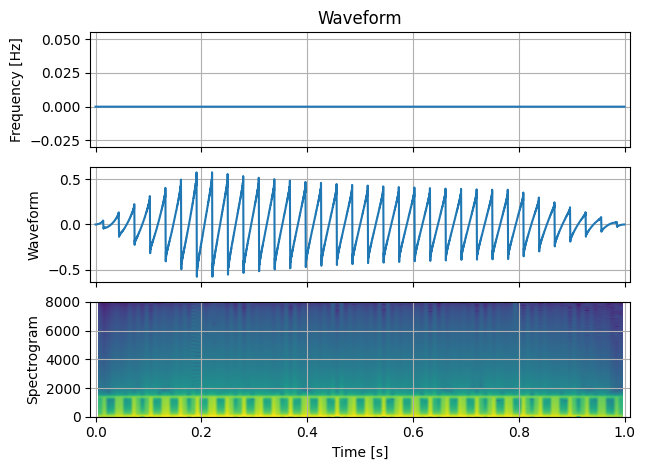

In [6]:
# Display
example_n = 157

plot(torch.zeros((1, NUM_FRAMES))[0], ys[example_n], SAMPLE_RATE)

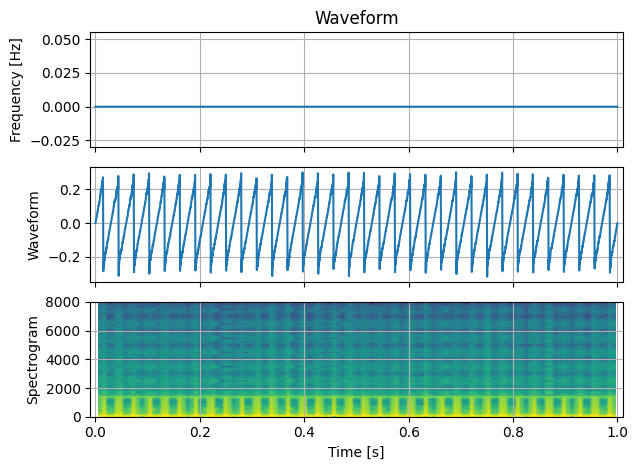

In [7]:
# Create NN
my_nn = text2synth.AmpEnvelopeNN(1000)

plot(torch.zeros((1, NUM_FRAMES))[0], my_nn(xs[example_n].unsqueeze(0), ps[example_n])[0], SAMPLE_RATE)

In [8]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, TensorDataset, DataLoader
import auraloss

from typing import List, Dict

class ADSRDataset(Dataset):

    def __init__(self, xs: torch.Tensor, ps: List[Dict[str, torch.Tensor]], ys: torch.Tensor):
        """
        Arguments:
            xs (torch.Tensor): The input tensors (e.g., audio signals).
            ps (List[Dict[torch.Tensor]]): List of dictionaries containing the 'adhsr' parameters.
            ys (torch.Tensor): The target tensors (e.g., envelopes).
        """
        self.xs = xs
        self.ps = ps
        self.ys = ys

    def __len__(self):
        return len(self.ps)

    def __getitem__(self, idx):
        return self.xs[idx], self.ps[idx], self.ys[idx]

train_set = ADSRDataset(xs, ps, ys)
train_dataloader = DataLoader(train_set, 64, True)

# Training Constants
EPOCHS = 20
LEARNING_RATE = 1e-3

# Loss function from auraloss
loss_fn = auraloss.time.LogCoshLoss()  # or L1Loss(), MRSTFTLoss(), etc.
optimizer = optim.Adam(my_nn.parameters(), lr=LEARNING_RATE)
scheduler = CosineAnnealingLR(optimizer, 20, eta_min=0.0)

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    num_batches = 0

    for (x, p, y) in train_dataloader:
        optimizer.zero_grad()

        output = my_nn(x, p)
        loss = loss_fn(output, y)

        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()
        num_batches += 1

    avg_loss = epoch_loss / num_batches

    if epoch % 2 == 0 or epoch == EPOCHS - 1:
        print(f"Epoch {epoch:04d} | Avg Loss: {avg_loss:.6f}")

C:\Users\12345\AppData\Local\Temp\ipykernel_21024\3741276788.py:54: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Scalar.cpp:23.)
  epoch_loss += loss.item()


Epoch 0000 | Avg Loss: 0.006962
Epoch 0002 | Avg Loss: 0.001799
Epoch 0004 | Avg Loss: 0.001109
Epoch 0006 | Avg Loss: 0.000815
Epoch 0008 | Avg Loss: 0.000644
Epoch 0010 | Avg Loss: 0.000539
Epoch 0012 | Avg Loss: 0.000468
Epoch 0014 | Avg Loss: 0.000417
Epoch 0016 | Avg Loss: 0.000378
Epoch 0018 | Avg Loss: 0.000345
Epoch 0019 | Avg Loss: 0.000331


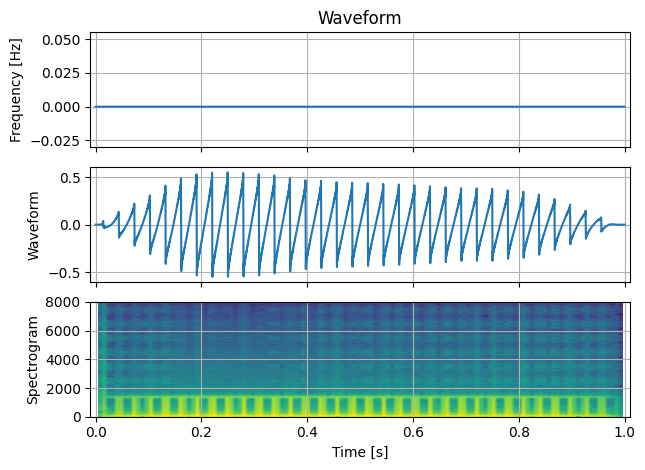

In [9]:
plot(torch.zeros((1, NUM_FRAMES))[0], my_nn(xs[example_n].unsqueeze(0), ps[example_n])[0], SAMPLE_RATE)

In [10]:
torch.save(my_nn, "adsr_1.pt")